# NYC Taxi Data, Hotel Pairing Experiment

This notebook is meant to serve as a proof-of-concept for pairing public record New York City taxi data (pick-ups, drop-offs) with a few hotels in the city.

In [1]:
# imports...
import csv, numpy as np, pandas as pd, matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

# matplotlib setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Importing and Cleaning Data

We first read the .csv file into memory and store the columns of the data which we want to use (Do we need any other columns besides latitude and longitude?).

For a first pass, I use the Green taxicab data from January 2016 from the NYC Taxi & Limousine Commission website (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). The Yellow taxicab datasets by month are ~1.65Gb, which takes a bit to load and even longer to process (calculate distances).

In [2]:
# change this if you want to try a different dataset
taxi_file = '../data/green_tripdata_2016-01.csv'

# let's load a single .csv file of taxi cab records (say, January 2016)
taxi_data = pd.read_csv(taxi_file)

# let's take a look at the loaded .csv file (for a sanity check)
taxi_data

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2016-01-01 00:29:24,2016-01-01 00:39:36,N,1,-73.928642,40.680611,-73.924278,40.698044,1,...,8.0,0.5,0.5,1.86,0.00,NaN,0.3,11.16,1,1.0
1,2,2016-01-01 00:19:39,2016-01-01 00:39:18,N,1,-73.952675,40.723175,-73.923920,40.761379,1,...,15.5,0.5,0.5,0.00,0.00,NaN,0.3,16.80,2,1.0
2,2,2016-01-01 00:19:33,2016-01-01 00:39:48,N,1,-73.971611,40.676105,-74.013161,40.646072,1,...,16.5,0.5,0.5,4.45,0.00,NaN,0.3,22.25,1,1.0
3,2,2016-01-01 00:22:12,2016-01-01 00:38:32,N,1,-73.989502,40.669579,-74.000648,40.689034,1,...,13.5,0.5,0.5,0.00,0.00,NaN,0.3,14.80,2,1.0
4,2,2016-01-01 00:24:01,2016-01-01 00:39:22,N,1,-73.964729,40.682854,-73.940720,40.663013,1,...,12.0,0.5,0.5,0.00,0.00,NaN,0.3,13.30,2,1.0
5,2,2016-01-01 00:32:59,2016-01-01 00:39:35,N,1,-73.891144,40.746456,-73.867744,40.742111,1,...,7.0,0.5,0.5,0.00,0.00,NaN,0.3,8.30,2,1.0
6,2,2016-01-01 00:34:42,2016-01-01 00:39:21,N,1,-73.896675,40.746197,-73.886192,40.745689,1,...,5.0,0.5,0.5,0.00,0.00,NaN,0.3,6.30,2,1.0
7,2,2016-01-01 00:31:23,2016-01-01 00:39:36,N,1,-73.953354,40.803558,-73.949150,40.794121,1,...,7.0,0.5,0.5,0.00,0.00,NaN,0.3,8.30,2,1.0
8,2,2016-01-01 00:24:40,2016-01-01 00:39:52,N,1,-73.994064,40.702816,-73.971573,40.679726,1,...,12.0,0.5,0.5,2.00,0.00,NaN,0.3,15.30,1,1.0
9,2,2016-01-01 00:28:59,2016-01-01 00:39:23,N,1,-73.914131,40.756641,-73.917549,40.739658,1,...,9.0,0.5,0.5,1.60,0.00,NaN,0.3,11.90,1,1.0


In [3]:
# get relevant rows of the data and store them as numpy arrays
pickup_longs, pickup_lats = np.array(taxi_data['Pickup_longitude']), np.array(taxi_data['Pickup_latitude'])
dropoff_longs, dropoff_lats = np.array(taxi_data['Dropoff_longitude']), np.array(taxi_data['Dropoff_latitude'])

# for brevity, let's just experiment with the first 10^6 datapoints.
pickup_coords = zip(pickup_longs[:1000000], pickup_lats[:1000000])
dropoff_coords = zip(dropoff_longs[:1000000], dropoff_lats[:1000000])

### Geolocating Hotels

We experiment with the geopy client for popular geolocation packages. We try the OpenStreetMap Nominatim service (https://nominatim.openstreetmap.org/), since it seems fairly accurate (investigate this?) and doesn't require authentication. I might move to Google's geolocation service (https://developers.google.com/maps/documentation/geolocation/intro) after obtaining an API key.

In [4]:
# change this variable to change the address to geolocate
hotel_address = '23 Nassau St, New York City, NY 10038' # The Beekman, A Thompson Hotel ("Best stay in New York!")

# setting up geolocator object
geolocator = Nominatim()

# storing the geocode of the above address
location = geolocator.geocode(hotel_address)
hotel_coords = (location.longitude, location.latitude)

print 'address:', location.address
print 'longitude, latitude:', hotel_coords

address: 23, Nassau Street, Southbridge Towers, Manhattan, New York County, NYC, New York, 10005, United States of America
longitude, latitude: (-74.0093998979592, 40.7088815510204)


### Finding Nearby Pickups and Corresponding Dropoff Locations

Now, we look through our pickup / dropoff dataset and find nearby points. We'll try a number of settings for "nearby", but they all rely on the "vincenty" distance (the default distance setting for this service), which calculates the distance between two points on a spheroid (https://en.wikipedia.org/wiki/Vincenty's_formulae). This can be measured in units of meters, miles, etc.

In [5]:
# first, we define a function which returns the destinations of all cab rides which originate within some distance
# of a hotel (given by latitude and longitude).

def get_destinations(pickup_coords, dropoff_coords, hotel_coords, distance, unit):
    '''
    A function which, given the latitude, longitude coordinates, returns an numpy array of (latitude, longitude) 
    pairs such that each pair corresponds to the destination of a taxicab ride orginating from within the distance
    specified in the units specified.
    
    input:
        pickup_coords: tuple of (pickup_longs, pickup_lats)
        dropoff_coords: typle of (dropoff_longs, dropoff_lats)
        hotel_coords: (latitude, longitude) of the hotel we are interested in as the starting point
        distance: a float specifying the distance from the hotel which we consider to be "close enough"
        unit: the unit of the distance parameter
    
    output:
        A numpy array of shape (2, M), where M is equal to the number of taxicab trips which satisfy the distance 
        criterion.
    '''
    
    # define variable to hold taxicab destinations starting from hotel
    destinations = []
    # get number of taxicab trips in dataset N
    N = len(pickup_coords)
    
    print '...getting nearby pickup locations and storing their destinations\n'

    # loop through each pickup long, lat pair
    for idx, pickup in enumerate(pickup_coords):
        
        # print progress to console periodically
        if idx % 100000 == 0:
            print 'progress: (' + str(idx) + ' / ' + str(N) + ')'
        
        # branch based off of unit of distance
        if unit == 'miles':
            # get distance in miles
            cur_dist = vincenty(hotel_coords, pickup).miles
        elif unit == 'meters':
            # get distance in meters
            cur_dist = vincenty(hotel_coords, pickup).meters
        else:
            raise NotImplementedError
                        
        # check for satisfaction of criterion (and throw away big outliers)  
        if cur_dist <= distance and vincenty(hotel_coords, dropoff_coords[idx]).miles < 50.0:
            # add dropoff coordinates to list if it meets the [unit] [distance] criterion
            destinations.append(dropoff_coords[idx])
            
    print 'progress: (' + str(N) + ' / ' + str(N) + ')\n'
    
    return np.array(destinations).T

In [6]:
%%time

# let's test out our function:
destinations = get_destinations(pickup_coords, dropoff_coords, hotel_coords, 1000.0, 'meters')

...getting nearby pickup locations and storing their destinations

progress: (0 / 1000000)
progress: (100000 / 1000000)
progress: (200000 / 1000000)
progress: (300000 / 1000000)
progress: (400000 / 1000000)
progress: (500000 / 1000000)
progress: (600000 / 1000000)
progress: (700000 / 1000000)
progress: (800000 / 1000000)
progress: (900000 / 1000000)
progress: (1000000 / 1000000)

CPU times: user 22.4 s, sys: 796 ms, total: 23.2 s
Wall time: 22.3 s


## Visualizing Destinations

This will help us get a feel for how the destinations from our selected hotel are distributed.

In [7]:
# we define a function to plot the destination coordinates

def plot_destinations(destinations, append_to_title):
    '''
    Plot destinations latitudes and longitudes to see a "map" of destinations.
    
    input:
        destinations: A numpy array of shape (2, M), where M is equal to the number of taxicab trips which satisfy
        the above distance criterion.
        append_to_title: String to append to the tite of the plot for context.
        
    output:
        Matplotlib plot of datapoints in the range of the latitude, longitude pairs.
    '''

    plt.plot(destinations[0], destinations[1], 'o')
    plt.title('Destinations From ' + append_to_title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

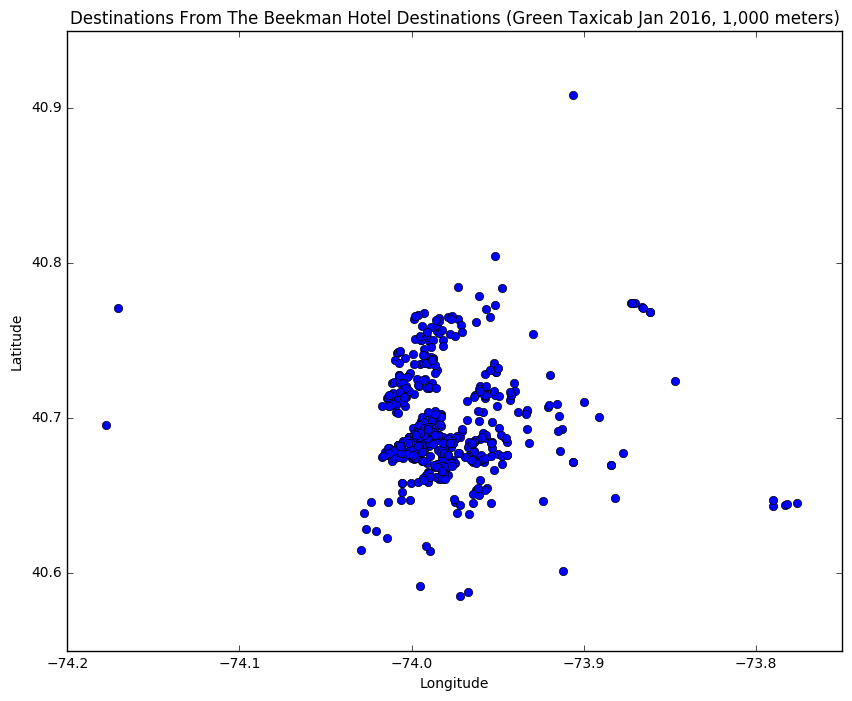

In [8]:
# try it out on the above returned destinations
plot_destinations(destinations, 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 1,000 meters)')

## Clustering Experiments

I want to try some scikit-learn (http://scikit-learn.org/stable/) clustering techniques in order to get a feel for the major destinations of the city to which these taxicab trips are traveling.

## K-Means Clustering with Cross-Validation on K

We try the K-Means clustering method (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_predict) and range over k in [2, 50], where k is the number of clusters to consider. We evaluate cluster quality using the silhouette score metric (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score), which is an intuitive way to calculate cluster coherence using mean intra- and nearest-cluster distance.

In [9]:
# more imports...
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [10]:
# function to do cross-validation on K-Means

def cv_kmeans(destinations, cluster_range=range(2, 31)):
    '''
    A function to perform K-Means, cross-validating on the number of clusters k.
    
    input:
        destinations: A numpy array of shape (2, M), where M is equal to the number of taxicab trips which satisfy
        the above distance criterion.
        cluster_range: the values of k to consider in the cross-validation.
        
    output:
        The best object score and correspond model, and the best silhouette score and the corresponding model.
    '''
    # create variables for best model and score
    best_score_model, best_silh_model, best_score, best_silh_score = None, None, -np.inf, -np.inf

    # range over values of k, the number of clusters to use, choose the k with the best objective score
    for k in cluster_range:
        # instantiate KMeans object
        model = MiniBatchKMeans(n_clusters=k)

        # fit the model and predict cluster indices of all coordinates
        labels = model.fit_predict(destinations.T)

        # compute score according to K-Means objective
        score = model.score(destinations.T)

        # compute silhouette score metric
        silh_score = silhouette_score(destinations.T, labels, sample_size=10000)

        # if this is the best scoring model so far
        if score > best_score:
            # update the best score and store the model
            best_score, best_score_model = score, model

        # if this is the best silhouette scoring mode so far
        if silh_score > best_silh_score:
            # update the best score and store the model
            best_silh_score, best_silh_model = silh_score, model
    
    return best_score, best_score_model, best_silh_score, best_silh_model

In [11]:
best_score, best_score_model, best_silh_score, best_silh_model = cv_kmeans(destinations)

print 'Best K-Means objective score:', best_score, '\n'
print 'Best K-Means objective model\'s number of clusters:', best_score_model.n_clusters, '\n'
print 'Best Silhouette score:', best_silh_score, '\n'
print 'Best Silhouette score model\'s number of clusters:', best_silh_model.n_clusters, '\n'

Best K-Means objective score: -0.0494737231529 

Best K-Means objective model's number of clusters: 23 

Best Silhouette score: 0.484566623841 

Best Silhouette score model's number of clusters: 4 



## Cluster Visualization

Since the above didn't really work that well (largest number of clusters maximizes objective score, very small number of clusters maximizes silhouette score), let's try fitting various clusterings and visualizing them in plots.

In [12]:
# creating a function to visualize a clustering of the destination data

def visualize_clustering(destinations, n_clusters, append_to_title):
    '''
    A function which fits a clustering model and plots its visualization in color.
    
    input:
        destinations: A numpy array of shape (2, M), where M is equal to the number of taxicab trips which satisfy
        the above distance criterion.
        n_clusters: The number of clusters to consider in doing K-Means clustering.
        append_to_title: String to append to the tite of the plot for context.
        
    output:
        A visualization of the clusters found by running the K-Means algorithm with the specified number of 
        clusters.
    '''
    # create model, fit it to data, get cluster indices
    model = MiniBatchKMeans(n_clusters=n_clusters)
    labels = model.fit_predict(destinations)
    centroids = model.cluster_centers_

    # plot the data and their cluster labels
    for clstr in range(n_clusters):
        # plot just the points in cluster i
        clstr_points = destinations[ np.where(labels == clstr) ]
        plt.plot(clstr_points[:, 0], clstr_points[:, 1], 'o')
        # plot the centroids
        lines = plt.plot(centroids[clstr, 0], centroids[clstr, 1], 'kx')
        # make the centroid x's bigger
        plt.setp(lines, ms=8.0)
        plt.setp(lines, mew=2.0)

    plt.title('Clustered Destinations ' + append_to_title)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()

## Plotting...

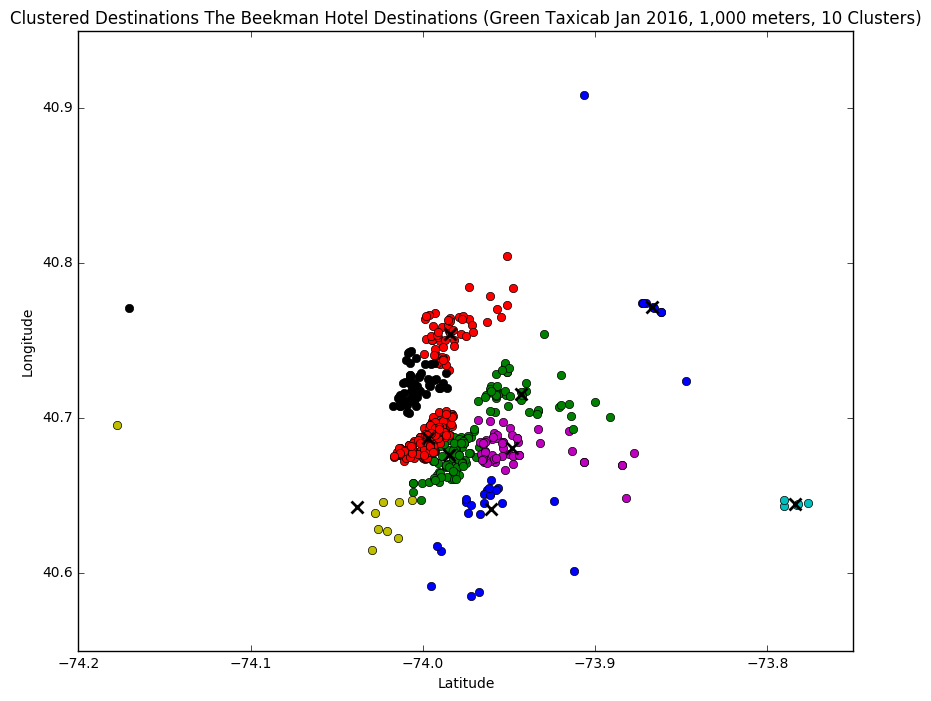

In [13]:
visualize_clustering(destinations.T, 10, 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 1,000 meters, 10 Clusters)')

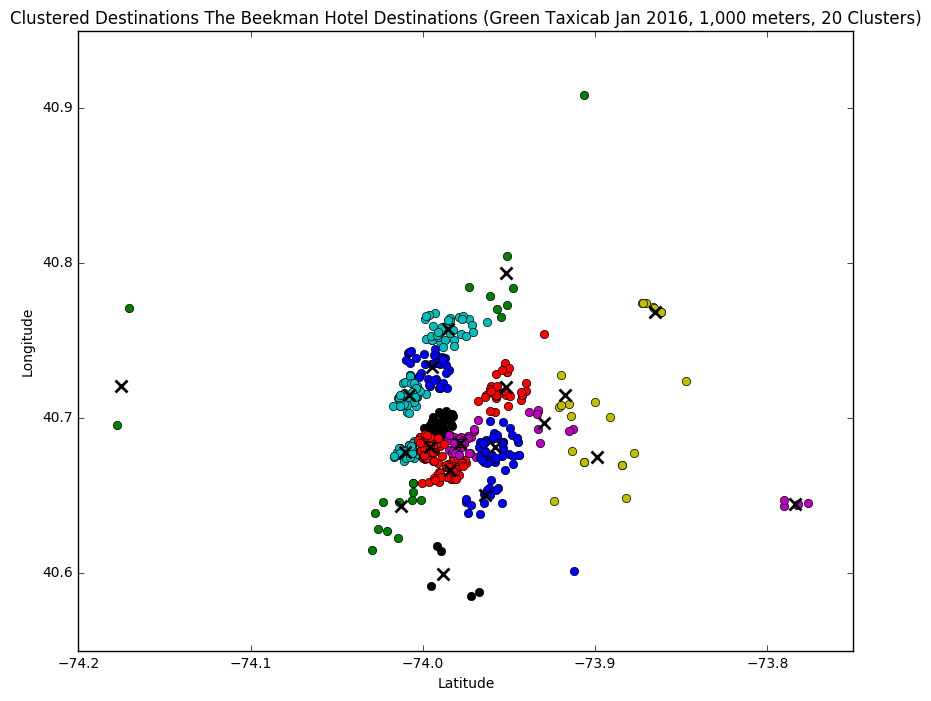

In [14]:
visualize_clustering(destinations.T, 20, 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 1,000 meters, 20 Clusters)')

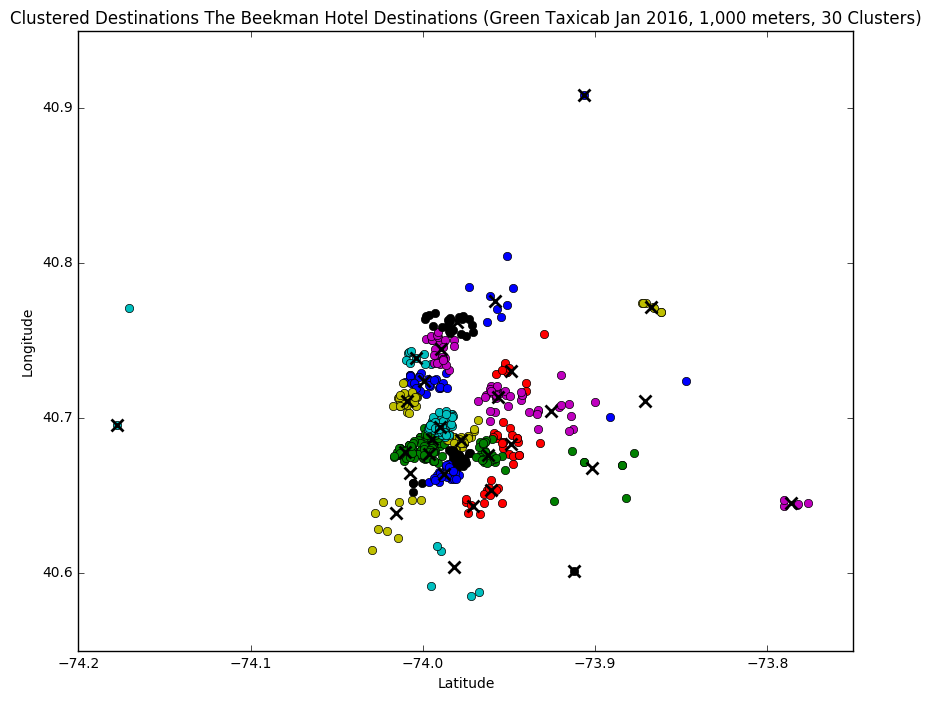

In [15]:
visualize_clustering(destinations.T, 30, 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 1,000 meters, 30 Clusters)')

Those looks pretty neat! Though, this technique probably won't be useful for the goals of the project.

Let's try the same experiment, but allow for points to be included at a greater distance (since this tiny dataset doesn't admit visualizations that are very interesting).

In [16]:
%%time

# getting destinations of trips starting within 10,000 meters of the specified hotel...
destinations = get_destinations(pickup_coords, dropoff_coords, hotel_coords, 2500.0, 'meters')

...getting nearby pickup locations and storing their destinations

progress: (0 / 1000000)
progress: (100000 / 1000000)
progress: (200000 / 1000000)
progress: (300000 / 1000000)
progress: (400000 / 1000000)
progress: (500000 / 1000000)
progress: (600000 / 1000000)
progress: (700000 / 1000000)
progress: (800000 / 1000000)
progress: (900000 / 1000000)
progress: (1000000 / 1000000)

CPU times: user 22.6 s, sys: 944 ms, total: 23.6 s
Wall time: 22.6 s


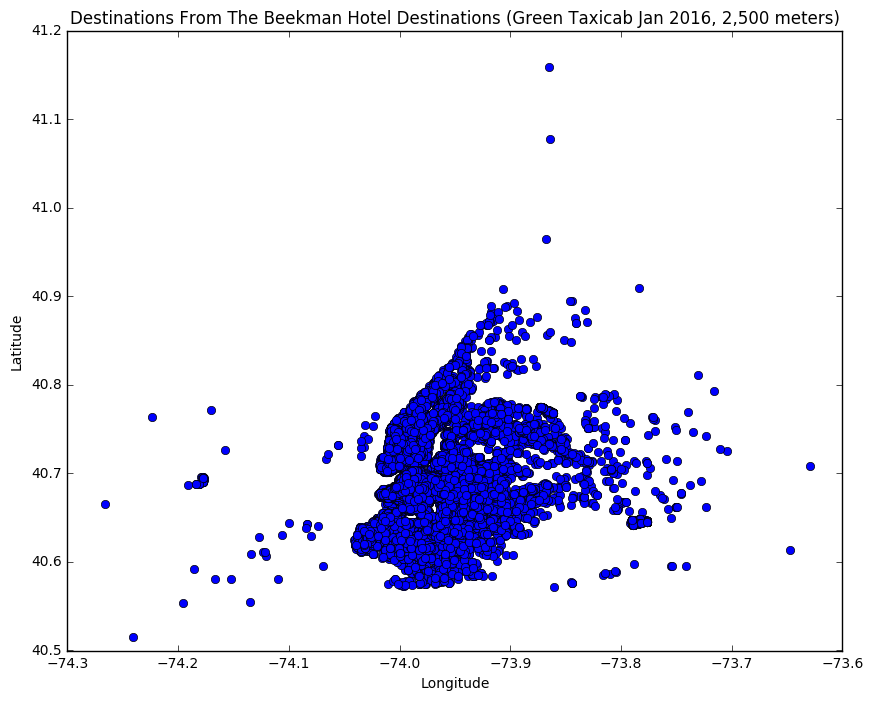

In [17]:
# plotting these destinations...
plot_destinations(destinations, 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 2,500 meters)')

In [18]:
best_score, best_score_model, best_silh_score, best_silh_model = cv_kmeans(destinations)

print 'Best K-Means objective score:', best_score, '\n'
print 'Best K-Means objective model\'s number of clusters:', best_score_model.n_clusters, '\n'
print 'Best Silhouette score:', best_silh_score, '\n'
print 'Best Silhouette score model\'s number of clusters:', best_silh_model.n_clusters, '\n'

Best K-Means objective score: -9.20777208394 

Best K-Means objective model's number of clusters: 28 

Best Silhouette score: 0.470144485598 

Best Silhouette score model's number of clusters: 3 



## Plotting...

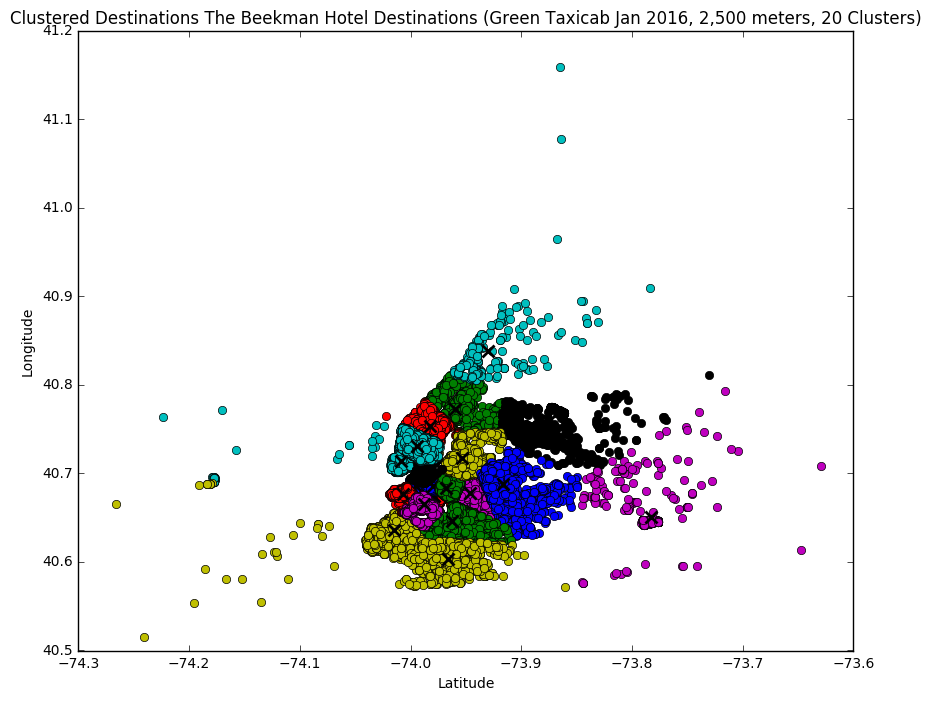

In [19]:
visualize_clustering(destinations.T, 20, 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 2,500 meters, 20 Clusters)')

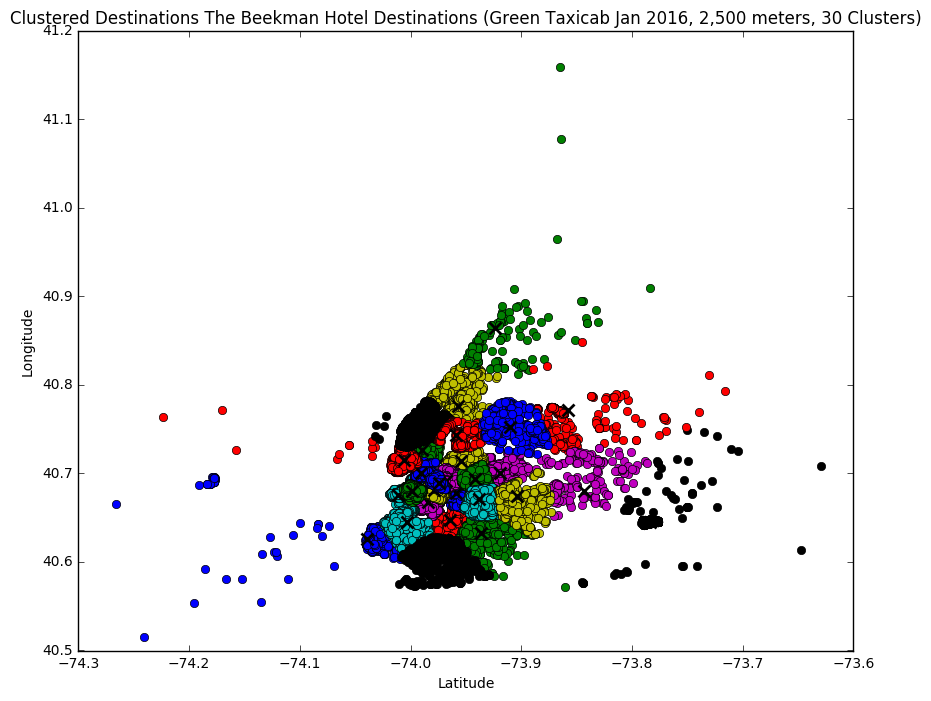

In [20]:
visualize_clustering(destinations.T, 30, 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 2,500 meters, 30 Clusters)')

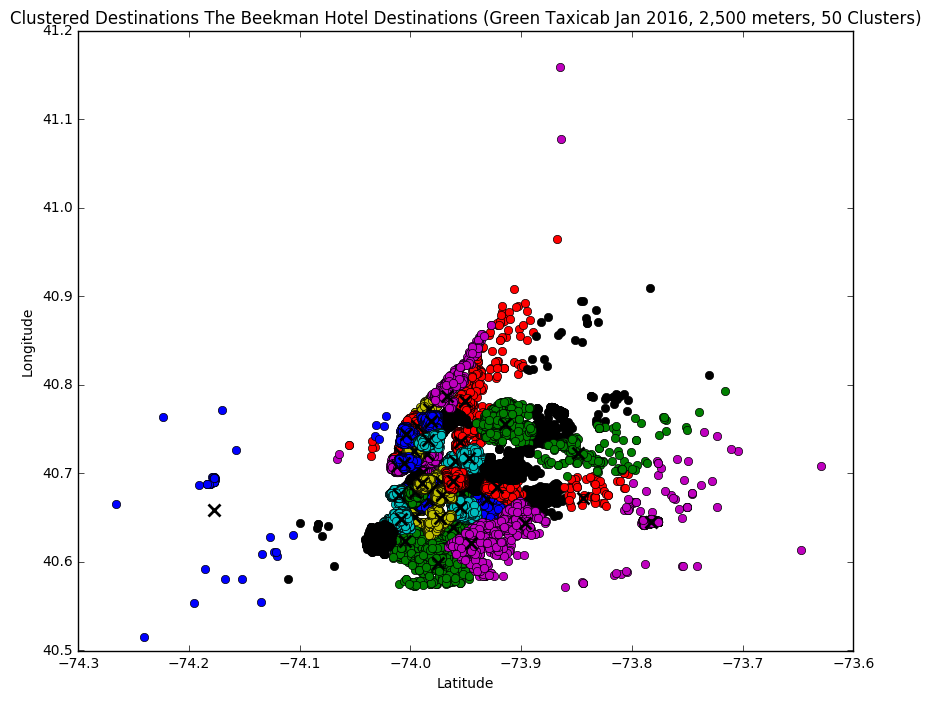

In [22]:
visualize_clustering(destinations.T, 50, 'The Beekman Hotel Destinations (Green Taxicab Jan 2016, 2,500 meters, 50 Clusters)')

## Conclusions

These clustering methods and visualization probably won't be that useful in this format, but it is enlightening to play around with the data. Experimentation with other clustering techniques might prove a better approach (it will be important to use much larger datasets! Something my laptop is not equipped to handle). After finding appropriate "cluster centers", we can then use the geopy Python software package to find the address of the attraction which is located at each cluster center.

As for usefulness, even on my laptop, processing 10^6 records in this fashion takes about 20 seconds per hotel. I am confident that parallelizing this code and deploying it on a cloud computing resource (e.g., Amazon Elastic Cloud or something similar) should make the number crunching very doable. 

As mentioned previously, I think that having a list of hotels and their addresses would be the next logical step. From there, it is easy to find their latitude and longitude, and then use this to calculate pick-up and drop-off distances.